In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os
from pathlib import Path
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import logging
logging.getLogger('tensorflow').disabled = True

# set seed and path
SEED = 17
ROOT = Path('.')
TRAIN_FILE = ROOT / 'data/train.csv'

# check your current working directory
# !pwd

In [2]:
train = pd.read_csv(TRAIN_FILE)
y = train['ACTION']
train = train[['RESOURCE', 'MGR_ID',
               'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
               'ROLE_CODE']]
display(train.dtypes,
       train.shape,
       train.head(),
       'TARGET',
       y.value_counts())

RESOURCE            int64
MGR_ID              int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object

(32769, 5)

,RESOURCE,MGR_ID,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117906,290919,117908
1,17183,1540,118536,308574,118539
2,36724,14457,267952,19721,117880
3,36135,5396,240983,290919,118322
4,42680,5905,123932,19793,119325


'TARGET'

1    30872
0     1897
Name: ACTION, dtype: int64

* Data 簡介
這次的示範資料集是從Kaggle上2013年的[Amazon員工訪問權限預測挑戰賽](https://www.kaggle.com/c/amazon-employee-access-challenge)中取得
這個資料集，該資料集收集了Amazon公司中各個員工針對每個資源(例如網頁的logging)的訪問紀錄，當員工屬於能夠取得訪問權限時，系統卻不給訪問，又要向上申請才能取得權限，一來一往浪費的非常多時間，因此這場比賽希望能夠建構模型，減少員工訪問權限所需的人工流程，我們取出5個特徵如下 :


* Feature (X)

> RESOURCE : 資源ID

> MGR_ID : 員工主管的ID 

> ROLE_FAMILY_DESC : 員工類別擴展描述 (例如 軟體工程的零售經理)

> ROLE_FAMILY : 員工類別 (例如 零售經理)

> ROLE_CODE : 員工角色編碼 (例如 經理)

* Target (Y)

> ACTION : 

 >> 1 : RESOURCE 訪問權限取得
 
 >> 0 : RESOURCE 禁止訪問

In [3]:
# helper function
def get_score(model, X, y, X_val, y_val):
    model.fit(X, y)
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    return score

In [4]:
LogReg_model = LogisticRegression(random_state=SEED)
xgb_model = XGBClassifier(random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=SEED)



In [5]:
for col in X_train.columns:
    print(col , 'uniques : ',X_train[f'{col}'].nunique())

RESOURCE uniques :  6711
MGR_ID uniques :  4062
ROLE_FAMILY_DESC uniques :  2201
ROLE_FAMILY uniques :  67
ROLE_CODE uniques :  337


# label encoding

In [6]:
baseline_logit_score = get_score(LogReg_model, X_train, y_train, X_val, y_val)
baseline_xgb_score = get_score(xgb_model, X_train, y_train, X_val, y_val)
print('Logistic Regression Label encoding:', baseline_logit_score)
print('Xgboost Label encoding:', baseline_xgb_score)

Logistic Regression Label encoding: 0.5350998573215817
Xgboost Label encoding: 0.7271242303799603


# One hot encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(sparse=True)

print('Original number of features:', X_train.shape[1])
data_ohe_train = (one_hot_enc.fit_transform(X_train))
data_ohe_val = (one_hot_enc.transform(X_val))
print('Features after OHE', data_ohe_train.shape[1])


Original number of features: 5
Features after OHE 13378


In [8]:
ohe_logit_score = get_score(LogReg_model, data_ohe_train, y_train, data_ohe_val, y_val)
ohe_xgb_score = get_score(xgb_model, data_ohe_train, y_train, data_ohe_val, y_val)
print('Logistic Regression OneHot encoding:', ohe_logit_score)
print('Xgboost OneHot encoding:', ohe_xgb_score)

Logistic Regression OneHot encoding: 0.8658363819423944
Xgboost OneHot encoding: 0.7223277228383869


# Target encoding


In [9]:
def TargetEncoder(train, test, ft, target, 
                   min_samples_leaf=1,
                   smoothing_slope=1,
                   noise_level=0,
                   handle_missing='informed', handle_unseen='overall_mean',
                   verbose=True):
    '''
        Tree model 處理 high cardinality特徵的方法, (例如, 地區, 地址, IP...)
        由於特徵非線性且基數高，導致Tree model非常容易overfitting，
        Target encoding的中心思想為 :
        將類別特徵轉換為數值特徵，使用該特徵中每個種類的sooth_mean，
        smooth_mean可以理解為，當該種類出現的次數越多次，我們就越相信該平均值，否則資訊量太少，
        我們傾向相信總平均值。
        公式為 : smooth_mean = smoothing_factor * estimated_mean + (1 - smoothing_factor) * overall mean
        其中 smoothing_factor =  1 / (1 + np.exp(-(counts - min_samples_leaf) / smoothing_slope))
        when min_samples_leaf, smoothing_slope fixed, counts -> infinity, smoothing_factor -> 1
        min_sample_leaf 為曲線的反曲點, 當counts = min_sample_leaf 時， smoothing_factor = 0.5
        smoothing_slope 為曲線從反曲點趨近於0和1的增加量 :
        當smoothing_slope -> infinity, smoothing_factor = 0.5
        當smoothing_slope -> 0 smoothing_factor -> step function
        
    :param train: pd.DataFrame
    :param test: pd.DataFrame 
    :param ft: string 
    :param target : pd.Series with target name
    :param noise_level: float  noise level
    :param handle_missing: string 'overall_mean','informed'
    :param handle_unseen: string 'overall_mean','return_nan'
    :param verbose: bool, check the unseen in testing set
    :return: train - pd.Series, test, - pd.Series target encoding result
    
    '''

    def add_noise(s: 'pd.Series', noise_level: int) -> 'pd.Series':
        return s * (1 + noise_level * np.random.randn(len(s)))
    
    train = pd.concat([train, target], axis=1)
    target_name = target.name
    overall_mean = target.mean()

    # handling missing value - filling
    train[ft].fillna('is_missing')
    test[ft].fillna('is_missing')

    # Compute the number of values and the estimated_mean of each group
    agg = train.groupby(ft)[target_name].agg(['count', 'mean'])
    counts = agg['count']
    estimated_mean = agg['mean']

    if handle_missing == 'overall_mean':
        # assign zero to group "is_missing", then smooth will be overall_mean
        counts.is_missing = 0

    # Compute the "smoothed" overall_means
    # DEFAULT take missing value is informed

    smoothing_factor = 1 / (1 + np.exp(- (counts - min_samples_leaf) / smoothing_slope))
    smooth_mean = (smoothing_factor * estimated_mean + (1 - smoothing_factor) * overall_mean)

    # create seen variable for test
    test_seen = test[ft].map(smooth_mean)
    unseen_ratio = test_seen.isnull().sum() / len(test)

    # return nan for unseen variable
    if handle_unseen == 'return_nan':
        return add_noise(train[ft].map(smooth_mean), noise_level), add_noise(test_seen, noise_level)

    if verbose:
        print(f'feature "{ft}" overall_mean is : ', round(overall_mean, 3))
        print(f'feature "{ft}" unssen ratio in test set is : ', round(unseen_ratio, 3))

    # DEFAULT return overall_mean for unseen variable
    return add_noise(train[ft].map(smooth_mean), noise_level), add_noise(test_seen.fillna(overall_mean), noise_level)

In [10]:
data_te_train = X_train.copy()
data_te_val = X_val.copy()
for feature in data_te_train.columns:
    data_te_train[f'{feature}_te'], data_te_val[f'{feature}_te'] = TargetEncoder(data_te_train,
                                                                           X_val, ft=feature,
                                                                           target=y_train,
                                                                      min_samples_leaf=3, smoothing_slope=2)

feature "RESOURCE" overall_mean is :  0.942
feature "RESOURCE" unssen ratio in test set is :  0.132
feature "MGR_ID" overall_mean is :  0.942
feature "MGR_ID" unssen ratio in test set is :  0.032
feature "ROLE_FAMILY_DESC" overall_mean is :  0.942
feature "ROLE_FAMILY_DESC" unssen ratio in test set is :  0.028
feature "ROLE_FAMILY" overall_mean is :  0.942
feature "ROLE_FAMILY" unssen ratio in test set is :  0.0
feature "ROLE_CODE" overall_mean is :  0.942
feature "ROLE_CODE" unssen ratio in test set is :  0.001


In [11]:
te_col = [feature for feature in data_te_train.columns
                              if feature.endswith('_te')]
# Training
target_logit_score = get_score(LogReg_model, data_te_train[te_col], y_train, data_te_val[te_col], y_val)
target_xgb_score = get_score(xgb_model, data_te_train[te_col], y_train, data_te_val[te_col], y_val)
print('Logistic Regression Target encoding:', target_logit_score)
print('Xgboost Target encoding:', target_xgb_score)

Logistic Regression Target encoding: 0.8246538027664151
Xgboost Target encoding: 0.8289567782791435


# Regularized Target encoding

In [12]:
FOLDS = StratifiedKFold(n_splits=5, random_state=SEED)
VAL_FOLDS = KFold(n_splits=5, random_state=SEED)

data_te_cv_train = X_train.copy()
data_te_cv_val = X_val.copy()
oof_trn_list = []
oof_test_list = []

for (trn_idx, val_idx), (_, test_idx) in zip(FOLDS.split(data_te_cv_train, y_train),
                                             VAL_FOLDS.split(data_te_cv_val)):
    X_train_te, y_train_te = data_te_cv_train.iloc[trn_idx], y_train.iloc[trn_idx]
    X_val_te, y_val_te = data_te_cv_train.iloc[val_idx], y_train.iloc[val_idx]
    X_test_te = data_te_cv_val.iloc[test_idx]
    
    for feature in X_train_te.columns:
        X_train_te[f'{feature}_te'], X_val_te[f'{feature}_te'] = TargetEncoder(X_train_te,
                                                                               X_val_te,
                                                                               ft=feature,
                                                                               target=y_train_te,
                                                                               min_samples_leaf=3,
                                                                               smoothing_slope=2,
                                                                               verbose=False)
        _, X_test_te[f'{feature}_te'] =TargetEncoder(X_train_te,
                                                    X_test_te,
                                                    ft=feature,
                                                    target=y_train_te,
                                                    min_samples_leaf=3,
                                                    smoothing_slope=2,
                                                    verbose=False)
    
    oof_trn_list.append(X_val_te.reset_index(drop=True))
    oof_test_list.append(X_test_te.reset_index(drop=True))

te_col = [feature for feature in data_te_train.columns
                              if feature.endswith('_te')]

data_te_cv_train = pd.concat(oof_trn_list,ignore_index=True)
data_te_cv_val = pd.concat(oof_test_list, ignore_index=True)

In [13]:
te_cv_logit_score = get_score(LogReg_model, data_te_cv_train[te_col], y_train, data_te_cv_val[te_col], y_val)
te_cv_xgb_score = get_score(xgb_model, data_te_cv_train[te_col], y_train, data_te_cv_val[te_col], y_val)
print('Logistic Regression Regularized Target encoding:', te_cv_logit_score)
print('Xgboost Regularized Target encoding:', te_cv_xgb_score)
# # Embedding

Logistic Regression Regularized Target encoding: 0.8324793713715402
Xgboost Regularized Target encoding: 0.8532191378849857


# Embedding

In [14]:
data_embedding_train = X_train.copy()
data_embedding_val = X_val.copy()

In [15]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, s : 'pd.Series') -> None:
        values = s.unique().tolist()
        self.feature_name = s.name
        # dictionary mapper
        self.embedding_dict = {value: int_value + 1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer.
        # we set unseen values as maximum value + 1 
        self.num_values = len(values) + 1

    def mapping(self,s : 'pd.Series', verbose = True) -> None:
        tmp_series = s.map(self.embedding_dict)
        unseen_ratio = round(tmp_series.isnull().sum() / len(s), 3)
        if verbose:
            print(f'Feature "{self.feature_name}"')
            print(f'    encode {self.num_values -1} values to label, {self.num_values} will be the unseen value ')
            print(f'    unssen ratio is : ', unseen_ratio)
        return tmp_series.fillna(self.num_values)

In [16]:
for feature in data_embedding_train.columns:
    Mapper = EmbeddingMapping(data_embedding_train[feature])
    data_embedding_train[f'{feature}'] = Mapper.mapping(data_embedding_train[f'{feature}'])
    data_embedding_val[f'{feature}'] = Mapper.mapping(data_embedding_val[f'{feature}'])

Feature "RESOURCE"
    encode 6711 values to label, 6712 will be the unseen value 
    unssen ratio is :  0.0
Feature "RESOURCE"
    encode 6711 values to label, 6712 will be the unseen value 
    unssen ratio is :  0.132
Feature "MGR_ID"
    encode 4062 values to label, 4063 will be the unseen value 
    unssen ratio is :  0.0
Feature "MGR_ID"
    encode 4062 values to label, 4063 will be the unseen value 
    unssen ratio is :  0.032
Feature "ROLE_FAMILY_DESC"
    encode 2201 values to label, 2202 will be the unseen value 
    unssen ratio is :  0.0
Feature "ROLE_FAMILY_DESC"
    encode 2201 values to label, 2202 will be the unseen value 
    unssen ratio is :  0.028
Feature "ROLE_FAMILY"
    encode 67 values to label, 68 will be the unseen value 
    unssen ratio is :  0.0
Feature "ROLE_FAMILY"
    encode 67 values to label, 68 will be the unseen value 
    unssen ratio is :  0.0
Feature "ROLE_CODE"
    encode 337 values to label, 338 will be the unseen value 
    unssen ratio is : 

In [27]:
LR = .00005
EPOCHS = 80
hidden_units = (16,4)
 
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

# Google's paper tell us a good herustic size = number of category ** 0.25
embedding_size_dict = {'RESOURCE': 9,
                       'MGR_ID': 8 ,
                      'ROLE_FAMILY_DESC': 7,
                      'ROLE_FAMILY': 3,
                      'ROLE_CODE':  4,
                      }

def build_and_train_model(df, target,  
                          verbose, hidden_units, epochs, LR,
                         embedding_size_dict, SEED):
    tf.set_random_seed(SEED); np.random.seed(SEED); random.seed(SEED)
    def build_input_and_embedding_layer(s, embedding_size_dict = embedding_size_dict):
        assert s.name in embedding_size_dict.keys()
        input_layer = keras.Input(shape=(1,), name = s.name)
        embedded_layer = keras.layers.Embedding(s.max() + 1, 
                                               embedding_size_dict[s.name],
                                               input_length=1, name = f'{s.name}_embedding')(input_layer)
        return input_layer, embedded_layer
    # Create embedding layer
    emb_layer_list = []
    input_layer_list = []
    for feature in df.columns:
        input_layer, embedded_layer = build_input_and_embedding_layer(df[feature], embedding_size_dict=embedding_size_dict)
        input_layer_list.append(input_layer)
        emb_layer_list.append(embedded_layer)
    # concat
    concatenated = keras.layers.Concatenate()(emb_layer_list)
    out = keras.layers.Flatten()(concatenated)
    
    # hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='relu')(out)
        out = Dropout(0.3)(out)
    # output layer
    out = keras.layers.Dense(1, activation='sigmoid', name='prediction')(out)
    
    # model
    model = keras.Model(
    inputs = input_layer_list,
    outputs = out)
#     model.summary()

    model.compile(
    tf.train.AdamOptimizer(LR),
    loss='binary_crossentropy',
    metrics=[auc],
    )
    tf.initialize_all_variables()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(
    [df[feature] for feature in df.columns],
    target,
    batch_size= 32,
    callbacks=[callback],
    epochs=epochs,
    verbose=verbose,
    validation_split = .1
    )
    return history

history = build_and_train_model(df = data_embedding_train,
                      target = y_train,
                      verbose=2, 
                      hidden_units=hidden_units,
                      epochs=EPOCHS,
                      LR=LR,
                      embedding_size_dict = embedding_size_dict,
                      SEED=SEED)

Train on 23593 samples, validate on 2622 samples
Epoch 1/80
23593/23593 - 3s - loss: 0.6529 - auc: 0.4997 - val_loss: 0.5982 - val_auc: 0.5116
Epoch 2/80
23593/23593 - 3s - loss: 0.5396 - auc: 0.5067 - val_loss: 0.4593 - val_auc: 0.5111
Epoch 3/80
23593/23593 - 3s - loss: 0.4203 - auc: 0.5084 - val_loss: 0.3374 - val_auc: 0.5061
Epoch 4/80
23593/23593 - 3s - loss: 0.3390 - auc: 0.5079 - val_loss: 0.2651 - val_auc: 0.5094
Epoch 5/80
23593/23593 - 3s - loss: 0.3015 - auc: 0.5104 - val_loss: 0.2312 - val_auc: 0.5116
Epoch 6/80
23593/23593 - 2s - loss: 0.2885 - auc: 0.5107 - val_loss: 0.2163 - val_auc: 0.5109
Epoch 7/80
23593/23593 - 2s - loss: 0.2720 - auc: 0.5129 - val_loss: 0.2075 - val_auc: 0.5162
Epoch 8/80
23593/23593 - 2s - loss: 0.2666 - auc: 0.5181 - val_loss: 0.2023 - val_auc: 0.5208
Epoch 9/80
23593/23593 - 2s - loss: 0.2534 - auc: 0.5240 - val_loss: 0.1979 - val_auc: 0.5273
Epoch 10/80
23593/23593 - 3s - loss: 0.2464 - auc: 0.5309 - val_loss: 0.1939 - val_auc: 0.5352
Epoch 11/8

[('embedding', <tensorflow.python.keras.callbacks.History object at 0x12e9db908>)] <class 'list'>


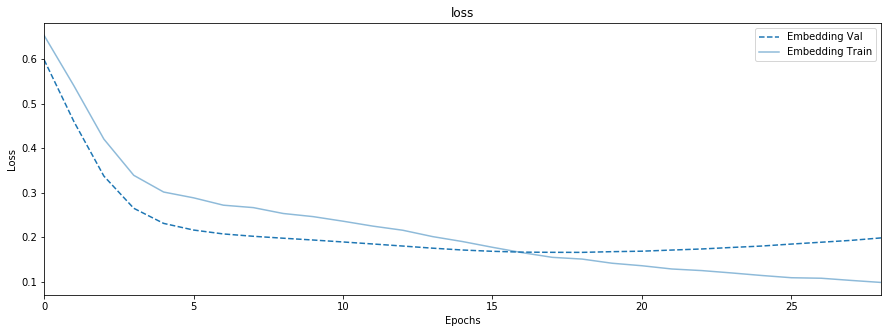

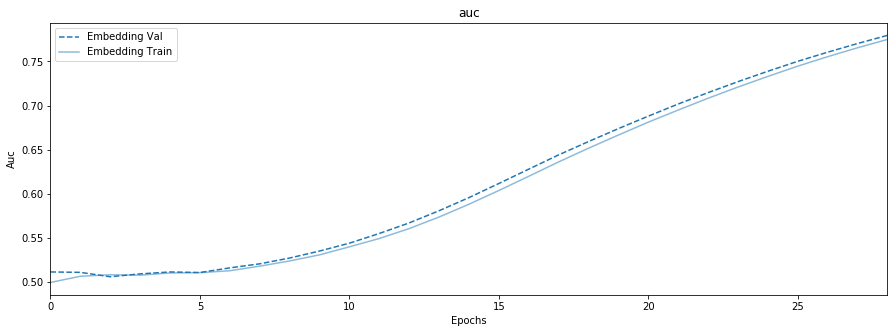

In [28]:
history_FS = (15, 5)
def plot_history(histories, keys=('loss','auc',), train=True, figsize=history_FS):
    if isinstance(histories, tf.keras.callbacks.History):
        histories = [ ('', histories) ]
        print(histories, type(histories))
    print(histories, type(histories))
    for key in keys:
        plt.figure(figsize=history_FS)
        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_'+key],
                           '--', label=str(name).title()+' Val')
            if train:
                plt.plot(history.epoch, history.history[key], color=val[0].get_color(), alpha=.5,
                         label=str(name).title()+' Train')
                
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.title(key)

        plt.xlim([0,max(max(history.epoch) for (_, history) in histories)])

plot_history([ 
    ('embedding', history)
])

In [29]:
model = history.model
embedding_vector_dict = {}
embedding_vector_column = {}
for feature in data_embedding_train.columns:
    print(f' processing ... {feature}_embedding')
    embedding_vector_dict[feature] = model.get_layer(f'{feature}_embedding').get_weights()[0]
    embedding_vector_column[feature] = [f'{feature}_emb_{i}' for i in range(embedding_vector_dict[feature].shape[1])]
print('Setup compelete')

 processing ... RESOURCE_embedding
 processing ... MGR_ID_embedding
 processing ... ROLE_FAMILY_DESC_embedding
 processing ... ROLE_FAMILY_embedding
 processing ... ROLE_CODE_embedding
Setup compelete


In [30]:
def get_embedding_vector(feature, feature_label, embedding_vector_dict):
    return embedding_vector_dict[feature][feature_label - 1,:]

In [31]:

data_embedding_train = data_embedding_train.astype(int).reset_index(drop=True)
data_embedding_val = data_embedding_val.astype(int).reset_index(drop=True)

data_embedding_train_prepared = data_embedding_train.copy()
data_embedding_val_prepared = data_embedding_val.copy()

for feature in data_embedding_train.columns:
    # train converting
    tmp_train_features_df = pd.DataFrame(get_embedding_vector(feature, data_embedding_train[feature],
                                                             embedding_vector_dict),
                                             columns=embedding_vector_column[f'{feature}'])

    # test converting
    tmp_test_features_df = pd.DataFrame(get_embedding_vector(feature,data_embedding_val[feature],
                                                            embedding_vector_dict),
                                    columns=embedding_vector_column[f'{feature}'])
    # train concat
    data_embedding_train_prepared = pd.concat([data_embedding_train_prepared, tmp_train_features_df],
                                               axis = 1)
    # test concat
    data_embedding_val_prepared = pd.concat([data_embedding_val_prepared, tmp_test_features_df],
                                             axis = 1)
    

In [32]:
from pandas.core.common import flatten
EMBEDDING_COLS = list(flatten(embedding_vector_column.values()))

In [33]:
embedding_logit_score = get_score(LogReg_model, 
                                  data_embedding_train_prepared[EMBEDDING_COLS],
                                  y_train,
                                  data_embedding_val_prepared[EMBEDDING_COLS],
                                  y_val)
embedding_xgb_score = get_score(xgb_model,
                                data_embedding_train_prepared[EMBEDDING_COLS],
                                y_train,
                                data_embedding_val_prepared[EMBEDDING_COLS],
                                y_val)
print('Logistic Regression Embedding encoding:', embedding_logit_score)
print('Xgboost Embedding encoding:', embedding_xgb_score)
# # Embedding

Logistic Regression Embedding encoding: 0.6163538547772671
Xgboost Embedding encoding: 0.7572997494342062
